In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits




In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
! eups list -s

afw                   g5b0a815229+07073039e0 	current w_2023_35 setup
alert_packet          gc1f99d08cb 	current w_2023_35 setup
analysis_drp          gfadca26dcd+7df23b908a 	current w_2023_35 setup
analysis_tools        g1887775915+12c68b5962 	current w_2023_35 setup
ap_association        g6758148a95+cc00875cc0 	current w_2023_35 setup
ap_pipe               g06c608b3b8+b6810408d8 	current w_2023_35 setup
ap_verify             g3bba7c13bf+c1b85e1378 	current w_2023_35 setup
astro_metadata_translator g0978aabd1f+2a7d2c9fe3 	current w_2023_35 setup
astshim               g3273194fdb+f6908454ef 	current w_2023_35 setup
atmospec              LOCAL:/home/m/monroy/repos/repos_w_2023_35/atmospec 	setup
base                  g98ffbb4407+81bc2a20b4 	current w_2023_35 setup
cbp                   ga32fcf49c8+ea6441928c 	current w_2023_35 setup
coadd_utils           g337abbeb29+ea6441928c 	current w_2023_35 setup
cp_pipe               g857a3418e4+7df23b908a 	current w_2023_35 setup
cp_verify       

# Butler 

In [6]:
import lsst.daf.butler as dafButler

In [7]:
embargo = True

In [8]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

In [9]:
cameraName = 'LATISS'
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    #print(col)
    calibCollections.append(col)

We check the different dimension records existing for *physical_filter*: 

In [10]:
phys_filters = list(registry.queryDimensionRecords('physical_filter',where="instrument='LATISS'"))

Print physical_filters with hologram in place: 

In [11]:
for f_ in phys_filters:
    if 'holo' in f_.name:
        print(f_.name)

empty~holo4_003
blank_bk7_wg05~holo4_003
KPNO_1111_436nm~holo4_003
KPNO_373A_677nm~holo4_003
KPNO_406_828nm~holo4_003
unknown~holo4_003
BG40~holo4_003
quadnotch1~holo4_003
RG610~holo4_003
FELH0600~holo4_003
SDSSg~holo4_003
SDSSr~holo4_003
SDSSi~holo4_003
BG40_65mm_1~holo4_003
BG40_65mm_2~holo4_003
OG550_65mm_1~holo4_003
OG550_65mm_2~holo4_003
SDSSg_65mm~holo4_003
SDSSr_65mm~holo4_003
SDSSi_65mm~holo4_003
SDSSu_65mm~holo4_003
SDSSz_65mm~holo4_003
SDSSy_65mm~holo4_003
empty~holo4_001
blank_bk7_wg05~holo4_001
KPNO_1111_436nm~holo4_001
KPNO_373A_677nm~holo4_001
KPNO_406_828nm~holo4_001
unknown~holo4_001
BG40~holo4_001
BG40_65mm_1~holo4_001
BG40_65mm_2~holo4_001
quadnotch1~holo4_001
RG610~holo4_001
OG550_65mm_1~holo4_001
OG550_65mm_2~holo4_001
FELH0600~holo4_001
SDSSg~holo4_001
SDSSr~holo4_001
SDSSi~holo4_001
SDSSu_65mm~holo4_001
SDSSg_65mm~holo4_001
SDSSr_65mm~holo4_001
SDSSi_65mm~holo4_001
SDSSz_65mm~holo4_001
SDSSy_65mm~holo4_001
collimator~holo4_003
collimator~holo4_001
cyl_lens~holo4_0

In [12]:
obs_type = 'science'
obs_day = 20230215
physical_filter = 'cyl_lens~holo4_003' #Note that there are no exposure with this config for the moment 

In [13]:
df_science = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num','time_start',
                                    'time_end' ,'type', 'target','filter_disp','zenith_angle',
                                    'expos','ra','dec','skyangle','science_program'])

In [14]:

#where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1} AND physical_filter='{2}'".format(obs_type,obs_day,physical_filter)
where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1}".format(obs_type,obs_day)
for i, info in enumerate(registry.queryDimensionRecords('exposure',where=where_exps)):
    
    #if info.observation_type=='science':
    id_ = info.id
    obs_id_ = info.obs_id
    day_obs_ = info.day_obs
    seq_num_ = info.seq_num
    timespan_ = info.timespan
    timespan_begin_ = pd.to_datetime(timespan_.begin.to_string())
    timespan_end_ = pd.to_datetime(timespan_.end.to_string())
    timespan_begin_jd_ = timespan_.begin.jd
    timespan_begin_mjd_ = timespan_.begin.mjd

    observation_type_ = info.observation_type
    target_name_ = info.target_name
    physical_filter_ = info.physical_filter
    zenith_angle_ = info.zenith_angle
    exposure_time_ = info.exposure_time
    tracking_ra_ = info.tracking_ra
    tracking_dec_ = info.tracking_dec
    sky_angle_ = info.sky_angle
    science_program_ = info.science_program

    df_science.loc[i] = [id_, obs_id_, day_obs_, seq_num_,timespan_begin_,timespan_end_ ,observation_type_, \
                         target_name_, physical_filter_, zenith_angle_, exposure_time_,tracking_ra_, \
                         tracking_dec_, sky_angle_, science_program_]

    if i < 2:
        print(i)
        print(info)
        print("\t timespan:            ",info.timespan)
        print("\t timespan.begin:      ",info.timespan.begin)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        print("-----------------------------------------------------")
    

0
exposure:
  instrument: 'LATISS'
  id: 2023021500236
  physical_filter: 'SDSSr_65mm~empty'
  obs_id: 'AT_O_20230215_000236'
  exposure_time: 1.0
  dark_time: 1.2411
  observation_type: 'science'
  observation_reason: 'object'
  day_obs: 20230215
  seq_num: 236
  seq_start: 236
  seq_end: 236
  group_name: '2023-02-16T01:07:25.241'
  group_id: 2564392452410000
  target_name: 'HD25025'
  science_program: 'unknown'
  tracking_ra: 59.509266282087005
  tracking_dec: -13.505257465867974
  sky_angle: 214.8946079090418
  azimuth: 292.2695592645051
  zenith_angle: 34.101158096725364
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2023-02-16 01:07:35.505985', scale='tai', format='iso'), end=astropy.time.Time('2023-02-16 01:07:36.747000', scale='tai', format='iso'))
	 timespan:             [2023-02-16T01:07:35.505985, 2023-02-16T01:07:36.747000)
	 timespan.begin:       2023-02-16 01:07:35.505985
	 id:                   2023021500236
	 day_obs:              20230215
	 seq_nu

In [15]:
print('Number of entries = ',len(df_science))

Number of entries =  389


In [16]:
df_science.tail(5)

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter_disp,zenith_angle,expos,ra,dec,skyangle,science_program
384,2023021500755,AT_O_20230215_000755,20230215,755,2023-02-16 07:28:02.006997,2023-02-16 07:28:32.238,science,E5-A_010,SDSSi_65mm~empty,16.355978,30.0,180.595065,-45.784026,359.998518,AUXTEL_DRP_IMAGING
385,2023021500756,AT_O_20230215_000756,20230215,756,2023-02-16 07:28:46.502994,2023-02-16 07:29:16.734,science,E5-A_010,SDSSg_65mm~empty,16.401310,30.0,180.595023,-45.784011,359.998586,AUXTEL_DRP_IMAGING
386,2023021500757,AT_O_20230215_000757,20230215,757,2023-02-16 07:29:19.209998,2023-02-16 07:29:49.442,science,E5-A_010,SDSSg_65mm~empty,16.436042,30.0,180.595007,-45.783998,359.998518,AUXTEL_DRP_IMAGING
387,2023021500758,AT_O_20230215_000758,20230215,758,2023-02-16 07:30:04.856984,2023-02-16 07:30:35.099,science,E5-A_010,SDSSr_65mm~empty,16.485513,30.0,180.595036,-45.784002,359.998551,AUXTEL_DRP_IMAGING
388,2023021500759,AT_O_20230215_000759,20230215,759,2023-02-16 07:30:37.575012,2023-02-16 07:31:07.829,science,E5-A_010,SDSSr_65mm~empty,16.520654,30.0,180.595033,-45.784011,359.998568,AUXTEL_DRP_IMAGING


Select exposures: 

### For the moment, we take the sequence numnbers corresponding to the fits files that were given to us 

In [17]:
seq_nums = np.arange(276,281)
print(seq_nums)

[276 277 278 279 280]


We test retrieving one of them: 

In [18]:
seq_num0 = 279
exp_id0 = str(obs_day)+'00'+str(seq_num0)
exp_id0 = int(exp_id0)
print(exp_id0)

2023021500279


In [19]:
test_img = butler.get('raw', dataId={'exposure': exp_id0, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)

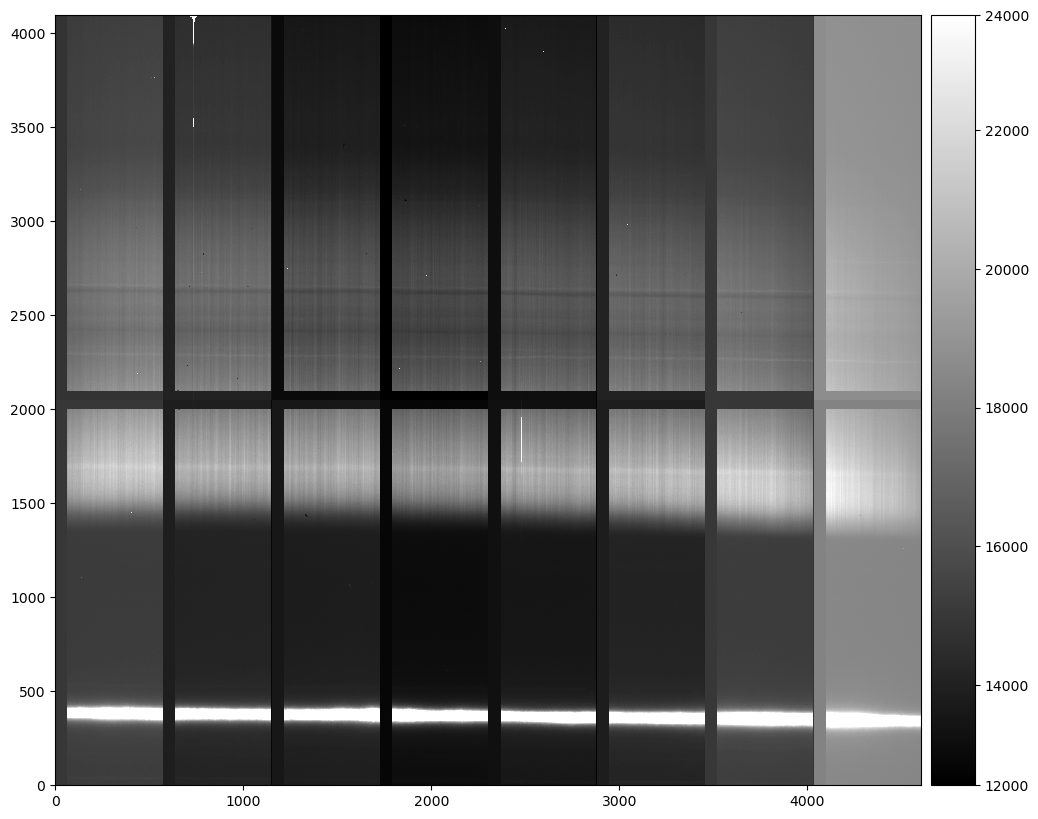

In [20]:
fig = plt.figure(figsize=(12,10))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('linear', 'zscale',None)
afw_display.mtv(test_img.image)

We do the ISR on this image the same way we do it with the spectra images (i.e., we do our pseudo-postISRCCD): 

In [21]:
# configuration
isr_config =  IsrTaskConfig()

In [22]:
isr_config.doDark = False
isr_config.doFlat =  False
isr_config.doFringe = False
isr_config.doDefect = True
isr_config.doLinearize = False
isr_config.doCrosstalk =  False
isr_config.doSaturationInterpolation = False
isr_config.overscan.fitType: 'MEDIAN_PER_ROW'
isr_config.doBias: True


In [23]:
isr_task = IsrTask(config=isr_config)

In [24]:
butler = dafButler.Butler(repo, collections=calibCollections)
camera = butler.get('camera', instrument=cameraName)
#bias = butler.get('bias',instrument=cameraName,detector=0)
#defects = butler.get('defects',instrument=cameraName,detector=0)

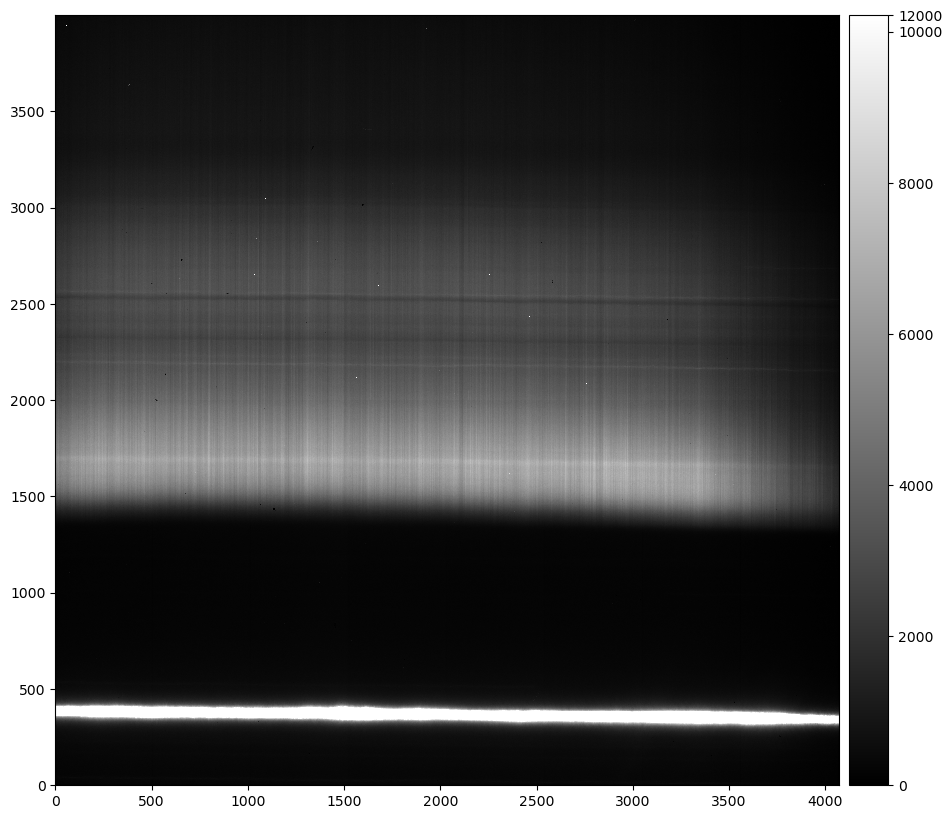

In [25]:

bias = butler.get("bias",instrument=cameraName, exposure= exp_id0, detector=0, collections=calibCollections)
defects = butler.get('defects',instrument=cameraName, exposure= exp_id0,detector=0,collections=calibCollections)

#fast ISR 
isr_test = isr_task.run(test_img,bias=bias,defects=defects)

%matplotlib inline

fig = plt.figure(figsize=(12,10))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('linear', 'zscale',None)
afw_display.mtv(isr_test.exposure.image)

Same plot but with matplotlib tools: 

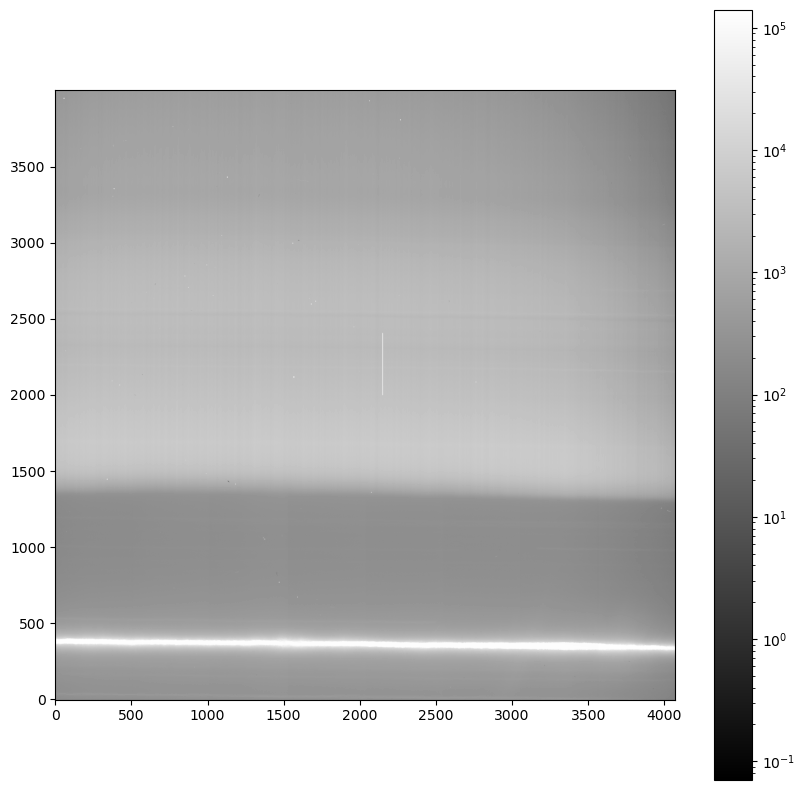

In [26]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
fig.colorbar(im,ax=ax)

We rotate the image the same way we do with the spectra images: 

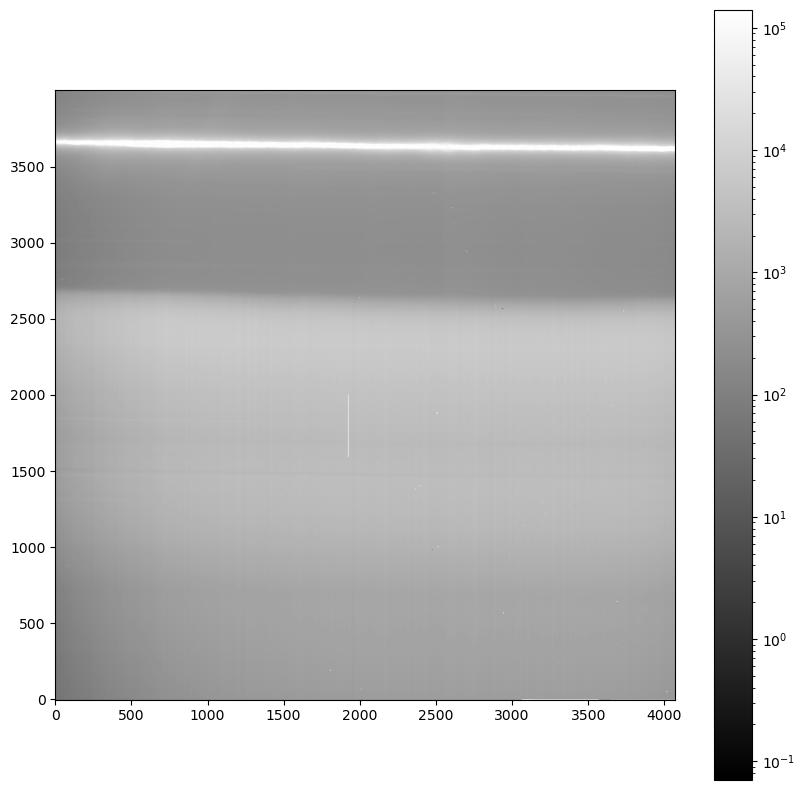

In [27]:
rotated_array = isr_test.exposure.image.array[::-1,::-1]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(rotated_array,cmap="gray",origin='lower',norm=LogNorm())
fig.colorbar(im,ax=ax)

Now, we compare with the image that we were given in fits format: 

In [28]:
#image_path = '/sps/lsst/groups/auxtel/data/raw_ncsa/'+obs_date+'/'
image_path = './'
image_label = 'exposure_{0}_pseudo-postisrccd.fits'
image_name = os.path.join(image_path,image_label)
print(image_name)

./exposure_{0}_pseudo-postisrccd.fits


In [29]:
f0 = fits.open(image_name.format(exp_id0))

In [30]:
f0[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4072                                                  
NAXIS2  =                 4000                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               

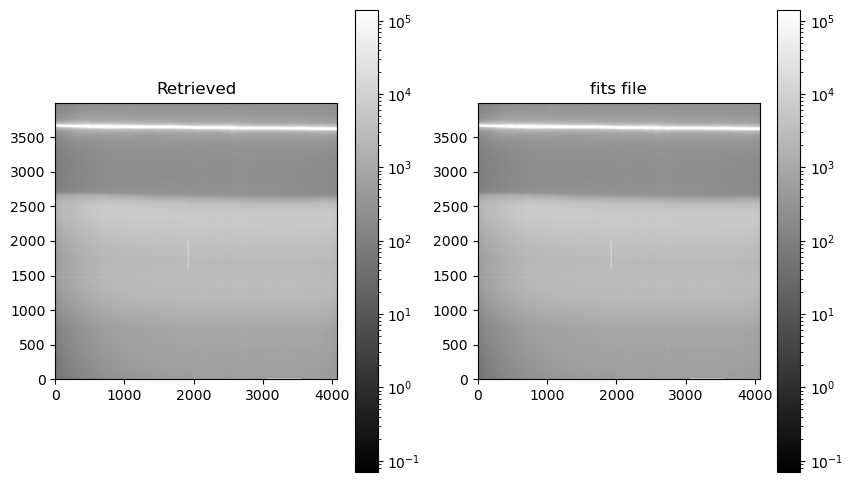

In [31]:
data0 = f0[1].data
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(121)
im = ax.imshow(rotated_array,cmap="gray",origin='lower',norm=LogNorm())
ax.set_title('Retrieved')
fig.colorbar(im,ax=ax)
ax = fig.add_subplot(122)
im = ax.imshow(data0,cmap="gray",origin='lower',norm=LogNorm())
ax.set_title('fits file')
fig.colorbar(im,ax=ax)

In [32]:
print(data0.shape)
print(type(data0))

(4000, 4072)
<class 'numpy.ndarray'>


# Create sum exposure from individual exposures 

In [33]:
print(seq_nums)

[276 277 278 279 280]


In [92]:
exp_list = []
ampli_boxes = {}
ampli_names = []
for i,num_ in enumerate(seq_nums):
    exp_id_ = str(obs_day)+'00'+str(num_)
    exp_id_ = int(exp_id_)
    print(exp_id_)
    raw_img_ = butler.get('raw', dataId={'exposure': exp_id_, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)
    print('Raw image retrieved')
    
    bias_ = butler.get("bias",instrument=cameraName, exposure= exp_id_, detector=0, collections=calibCollections)
    defects_ = butler.get('defects',instrument=cameraName, exposure= exp_id_,detector=0,collections=calibCollections)
    
    #fast ISR 
    print('Running pseudo-ISR')
    isr_img_ = isr_task.run(raw_img_,bias=bias_,defects=defects_)
    
    exp_list.append(isr_img_)
    print('-----------------')
    
    if i==0:
        for ampIdx, amp in enumerate(raw_img_.getDetector()):
            ampli_name_ = amp.getName()
            ampli_names.append(ampli_name_)
            xbegin = amp.getBBox().x.begin
            xend = amp.getBBox().x.end
            ybegin = amp.getBBox().y.begin
            yend = amp.getBBox().y.end
            ampli_boxes[ampli_name_] = (xbegin,xend,ybegin,yend)
            
            md = raw_img_.getMetadata().toDict()
    

2023021500276
Raw image retrieved
Running pseudo-ISR


-----------------
2023021500277
Raw image retrieved
Running pseudo-ISR


-----------------
2023021500278
Raw image retrieved
Running pseudo-ISR


-----------------
2023021500279
Raw image retrieved
Running pseudo-ISR


-----------------
2023021500280
Raw image retrieved
Running pseudo-ISR


-----------------


In [48]:
ampli_boxes

{'C10': (0, 509, 2000, 4000),
 'C11': (509, 1018, 2000, 4000),
 'C12': (1018, 1527, 2000, 4000),
 'C13': (1527, 2036, 2000, 4000),
 'C14': (2036, 2545, 2000, 4000),
 'C15': (2545, 3054, 2000, 4000),
 'C16': (3054, 3563, 2000, 4000),
 'C17': (3563, 4072, 2000, 4000),
 'C07': (3563, 4072, 0, 2000),
 'C06': (3054, 3563, 0, 2000),
 'C05': (2545, 3054, 0, 2000),
 'C04': (2036, 2545, 0, 2000),
 'C03': (1527, 2036, 0, 2000),
 'C02': (1018, 1527, 0, 2000),
 'C01': (509, 1018, 0, 2000),
 'C00': (0, 509, 0, 2000)}

In [61]:
mapampid = [0,1,2,3,4,5,6,7,15,14,13,12,11,10,9,8]

In [62]:
num_amplis = len(mapampid)

## We test the normalization with one exposure 

In [49]:
exp0 = exp_list[0].exposure.image.array

In [50]:
print(exp0.shape)

(4000, 4072)


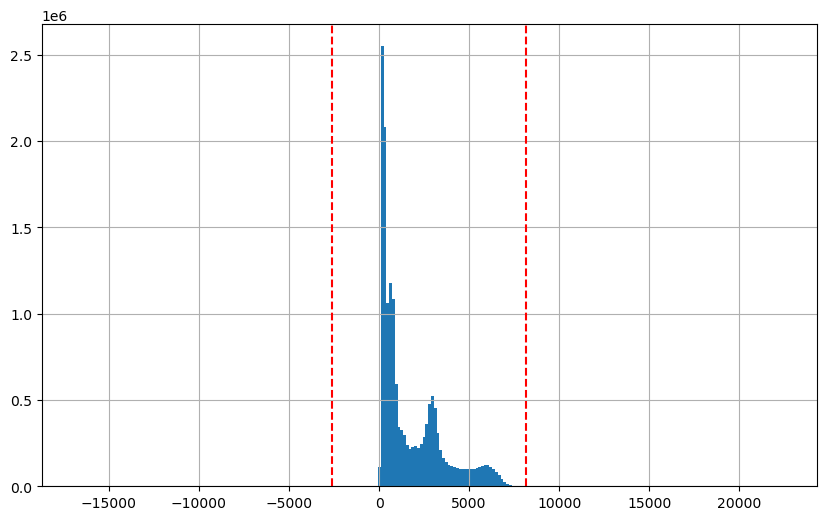

In [75]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
_ = ax.hist(exp0.flatten(),bins=1000)
mu = np.mean(exp0.flatten())
sigma = np.std(exp0.flatten())
nsigma = 0.5
ax.axvline(x=mu-nsigma*sigma,ls='--',color='r')
ax.axvline(x=mu+nsigma*sigma,ls='--',color='r')
ax.set_xlim(mu-2.*sigma,mu+2.*sigma)
ax.grid()

In [77]:
vmin = 1
vmax = 6000

(0.0, 4000.0)

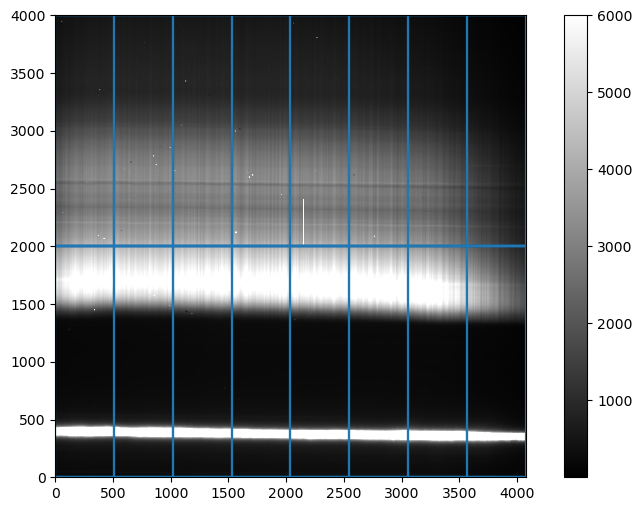

In [78]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
im = ax.imshow(exp0,cmap="gray",origin='lower',vmin=vmin,vmax=vmax)#,norm=LogNorm())
fig.colorbar(im,ax=ax)
for key in ampli_boxes.keys():
    ax.axvline(x=ampli_boxes[key][0])
    ax.axvline(x=ampli_boxes[key][1])
    ax.axhline(y=ampli_boxes[key][2])
    ax.axhline(y=ampli_boxes[key][3])
ax.set_xlim(0,4072)
ax.set_ylim(0,4000)

Visualize data per amplifier separately 

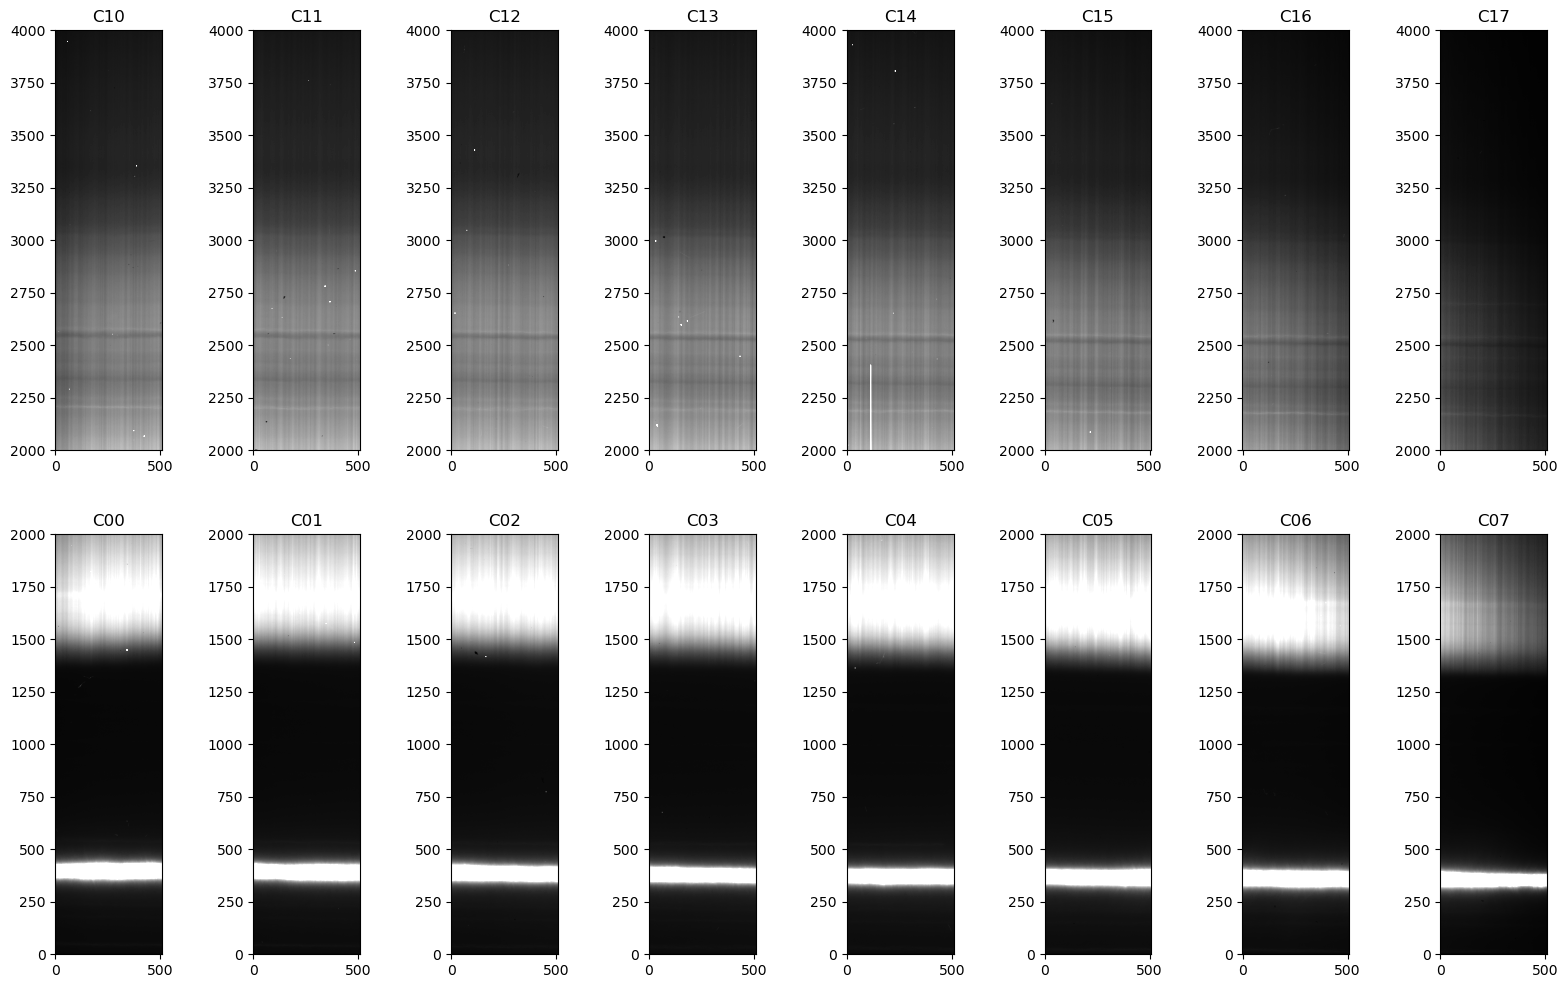

In [79]:
fig = plt.figure(figsize=(20,12))

for i,key in enumerate(ampli_boxes.keys()):
    x0 = ampli_boxes[key][0]
    x1 = ampli_boxes[key][1]
    y0 = ampli_boxes[key][2]
    y1 = ampli_boxes[key][3]
    ampli_ = exp0[y0:y1,x0:x1]
    
    ax = fig.add_subplot(2,8,mapampid[i]+1)
    im = ax.imshow(ampli_,cmap="gray",origin='lower',vmin=vmin,vmax=vmax)#,norm=LogNorm())
    yticks = ax.get_yticks()
    #print(yticks)
    ax.set_yticks(ticks=yticks[1:],labels=yticks[1:].astype('int')+y0)
    ax.set_title(key)

We normalize each row (per amplifier) to their median value. This way, we can compare exposure with different number counts (due to different effective exposure times) 

(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)


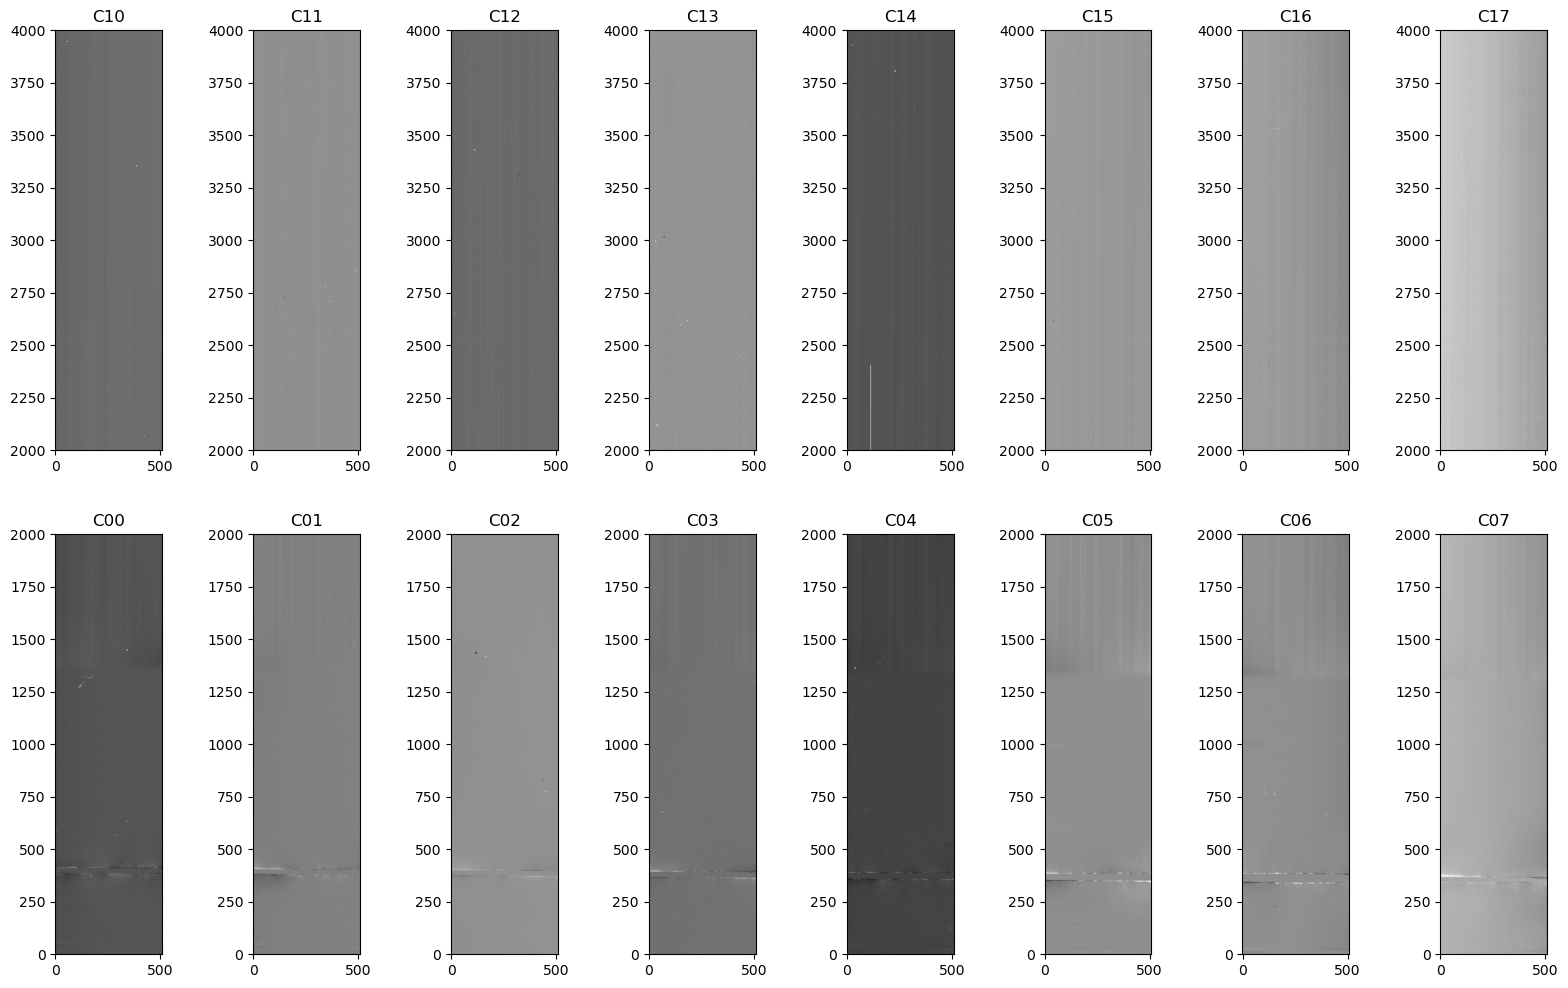

In [81]:
fig = plt.figure(figsize=(20,12))

for i,key in enumerate(ampli_boxes.keys()):
    x0 = ampli_boxes[key][0]
    x1 = ampli_boxes[key][1]
    y0 = ampli_boxes[key][2]
    y1 = ampli_boxes[key][3]
    ampli_ = exp0[y0:y1,x0:x1]
    median_ = np.median(ampli_,axis=1)
    
    norm_ampli_ = ampli_/median_[:,None]
    print(norm_ampli_.shape)
    
    ax = fig.add_subplot(2,8,mapampid[i]+1)
    im = ax.imshow(norm_ampli_,cmap="gray",origin='lower',norm=LogNorm())
    yticks = ax.get_yticks()
    #print(yticks)
    ax.set_yticks(ticks=yticks[1:],labels=yticks[1:].astype('int')+y0)
    ax.set_title(key)


## Now we do this systematically for all exposures and we combine taking their median pixel by pixel 

In [64]:
print(len(exp_list))

5


In [65]:
special_flat_ = []
for i,exp_ in enumerate(exp_list):
    print(i)
    data_ = exp_.exposure.image.array
    print(data_.shape)
    
    out_ = np.zeros(data_.shape)
    for key in ampli_boxes.keys():
        x0 = ampli_boxes[key][0]
        x1 = ampli_boxes[key][1]
        y0 = ampli_boxes[key][2]
        y1 = ampli_boxes[key][3]
        ampli_ = data_[y0:y1,x0:x1]
        median_ = np.median(ampli_,axis=1)

        norm_ampli_ = ampli_/median_[:,None]
        print(norm_ampli_.shape)
        
        out_[y0:y1,x0:x1] = norm_ampli_
    print(out_.shape)
    special_flat_.append(out_)
    print('-------------')
special_flat_ = np.array(special_flat_)
print(special_flat_.shape)

0
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------
1
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------
2
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------
3
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------
4
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(

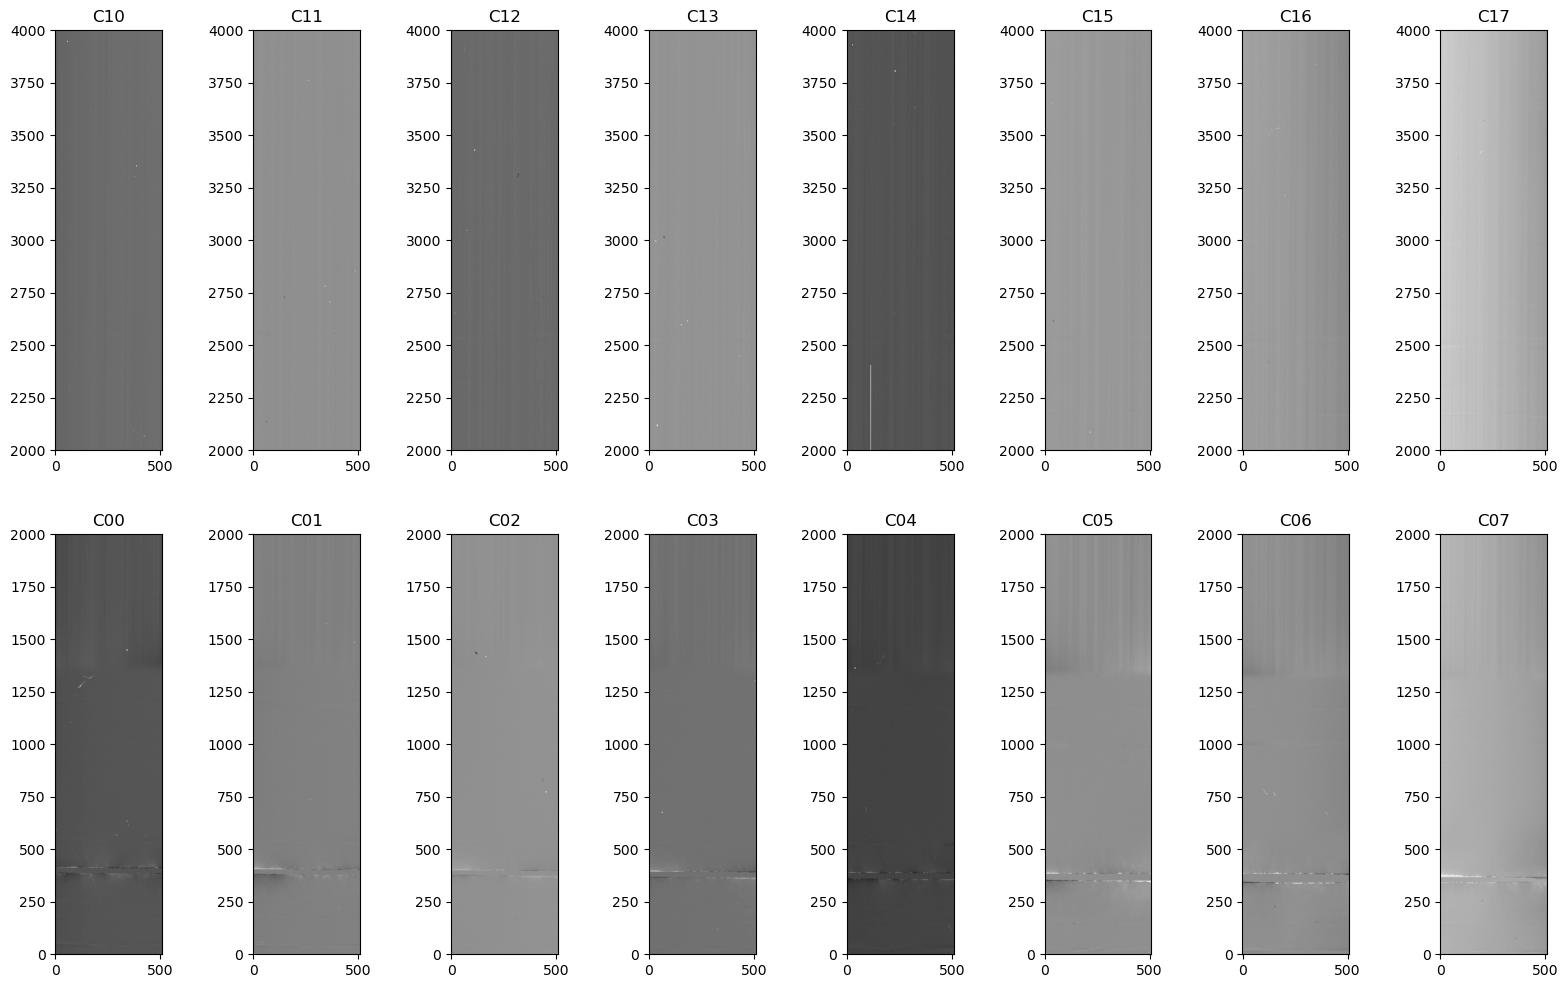

In [67]:
fig = plt.figure(figsize=(20,12))

for i,key in enumerate(ampli_boxes.keys()):
    x0 = ampli_boxes[key][0]
    x1 = ampli_boxes[key][1]
    y0 = ampli_boxes[key][2]
    y1 = ampli_boxes[key][3]
    ampli_ = special_flat_[0][y0:y1,x0:x1]
    
    ax = fig.add_subplot(2,8,mapampid[i]+1)
    im = ax.imshow(ampli_,cmap="gray",origin='lower',norm=LogNorm())
    yticks = ax.get_yticks()
    #print(yticks)
    ax.set_yticks(ticks=yticks[1:],labels=yticks[1:].astype('int')+y0)
    ax.set_title(key)

In [88]:
special_flat = np.median(special_flat_,axis=0)

In [89]:
print(special_flat.shape)

(4000, 4072)


(0.0, 4000.0)

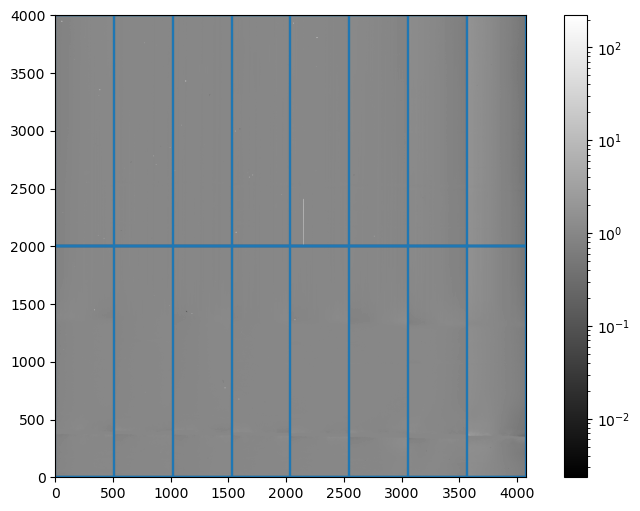

In [91]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
im = ax.imshow(special_flat,cmap="gray",origin='lower',norm=LogNorm())
fig.colorbar(im,ax=ax)
for key in ampli_boxes.keys():
    ax.axvline(x=ampli_boxes[key][0])
    ax.axvline(x=ampli_boxes[key][1])
    ax.axhline(y=ampli_boxes[key][2])
    ax.axhline(y=ampli_boxes[key][3])
ax.set_xlim(0,4072)
ax.set_ylim(0,4000)

In [ ]:
filename_out = 'cyl_lens_flat_{0}.fits'.format(flat_selected)
fullfilename_out = os.path.join(outdir,filename_out)

print(f">>>>  output filename {filename_out}")

hdr = fits.Header()
    
for key,value in md.items():
    hdr[str(key)] = value
    

# Be carefull for Spectractor, 2 hdu units are necessary

primary_hdu = fits.PrimaryHDU(header=hdr)
image_hdu = fits.ImageHDU(special_array)

hdu_list = fits.HDUList([primary_hdu, image_hdu])

hdu_list.writeto(fullfilename_out,overwrite=True)